In [652]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [654]:
# all the unique station in the provided dataset
unique_stations = ['FPZ_04A', 'FSB_126', 'FSB_079', 'FPZ_06A', 'FEX_004', 'FSB_078',
       'FSB_097D', 'FSB_130D', 'FSB_095DR']
finder = {}
for index, val in enumerate(unique_stations):
    finder[val]= index

finder

{'FPZ_04A': 0,
 'FSB_126': 1,
 'FSB_079': 2,
 'FPZ_06A': 3,
 'FEX_004': 4,
 'FSB_078': 5,
 'FSB_097D': 6,
 'FSB_130D': 7,
 'FSB_095DR': 8}

In [668]:
index = 4
df = pd.read_csv(f"../data/{unique_stations[index]}.csv")
df = df.dropna()
print(df.shape)

(7366, 21)


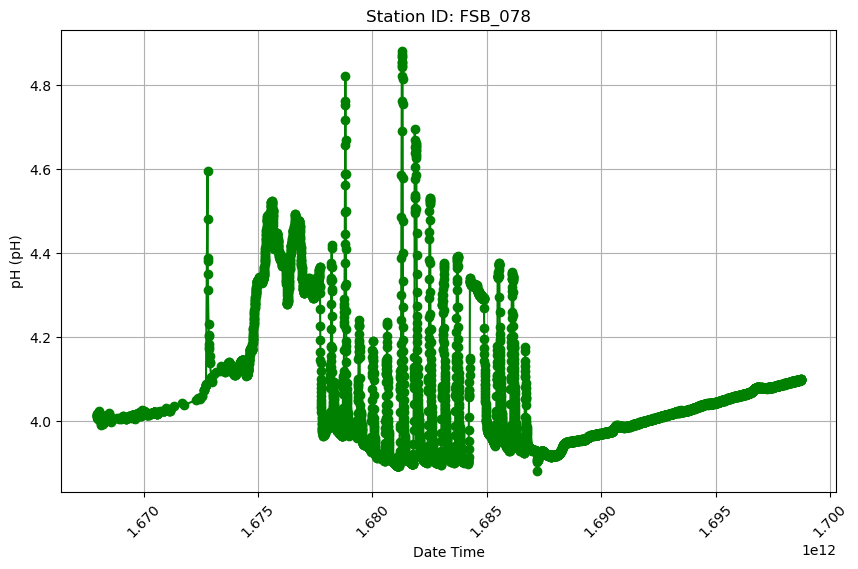

In [670]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date Time'], df['pH (pH)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078')
plt.xlabel('Date Time')
plt.ylabel('pH (pH)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [623]:
df = df.drop(columns = ["station_id","pH MV (mV)", "easting", "northing"])
df.shape

(16789, 17)

In [625]:
df.columns

Index(['Date Time', 'Actual Conductivity (ÂµS/cm)',
       'Specific Conductivity (ÂµS/cm)', 'Salinity (psu)',
       'Resistivity (â„¦-cm)', 'Density (g/cmÂ³)',
       'Total Dissolved Solids (mg/L)', 'pH (pH)', 'ORP (mV)', 'DO (mg/L)',
       '% Saturation Oâ‚‚ (% sat)', 'Partial Pressure Oâ‚‚ (psi)',
       'Temperature (C)', 'External Voltage (V)', 'Pressure (psi)',
       'Depth (m)', 'Level: Depth to Water (m)'],
      dtype='object')

In [691]:
min_date = df["Date Time"].min()
min_date

1667946840000.0

In [693]:
num_of_months = 1
temp_months = num_of_months * 30 * 24 * 60 * 60 * 1000
first_temp_months = df[df["Date Time"] <= temp_months + min_date]
first_temp_months.shape

(286, 21)

In [695]:
later_temp_months = df[df["Date Time"] > temp_months + min_date]
later_temp_months.shape

(7080, 21)

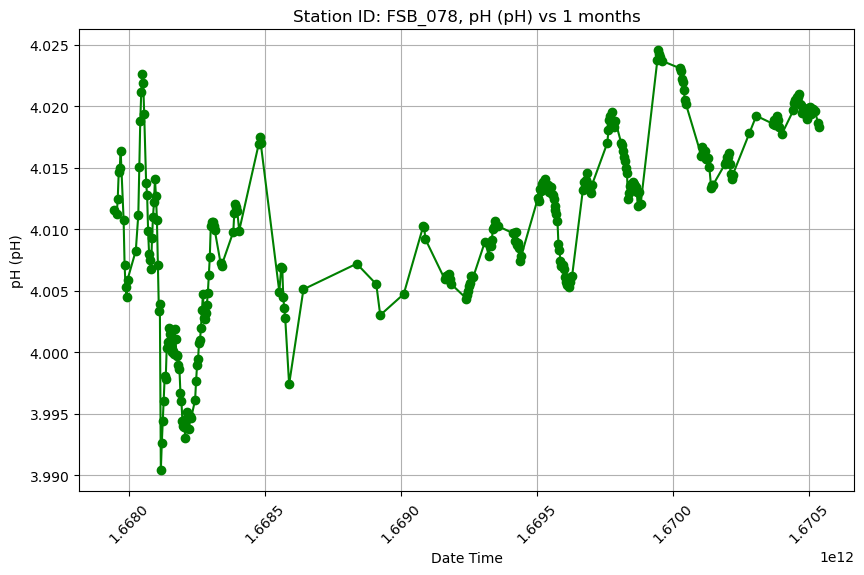

In [697]:
plt.figure(figsize=(10, 6))
plt.plot(first_temp_months['Date Time'], first_temp_months['pH (pH)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078, pH (pH) vs {num_of_months} months')
plt.xlabel('Date Time')
plt.ylabel('pH (pH)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [699]:
first_temp_months = first_temp_months.drop(columns = ["Date Time"])
later_temp_months =later_temp_months.drop(columns = ["Date Time"])
print(first_temp_months.shape)
print(later_temp_months.shape)

(286, 20)
(7080, 20)


In [701]:
X_train = first_temp_months.drop(columns = ["pH (pH)"])
y_train = first_temp_months["pH (pH)"].values.reshape(-1,1)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
y_train = X_scaler.fit_transform(y_train)

ValueError: could not convert string to float: 'FEX_004'

In [573]:
X_test = later_temp_months.drop(columns = ["pH (pH)"])
y_test = later_temp_months["pH (pH)"].values.reshape(-1,1)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_test = X_scaler.fit_transform(X_test)
y_test = X_scaler.fit_transform(y_test)

In [575]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
print(f"shape of training X and y are {X_train_tensor.shape}, {y_train_tensor.shape}")

shape of training X and y are torch.Size([366, 15]), torch.Size([366, 1])


In [577]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
print(f"shape of test X and y are {X_test_tensor.shape}, {y_test_tensor.shape}")

shape of test X and y are torch.Size([7000, 15]), torch.Size([7000, 1])


In [579]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [581]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [583]:
input_dim = training_data_X.shape[1]
output_dim = training_data_y.shape[1]

model = SimpleNN(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [585]:
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0069
Epoch [20/100], Loss: 0.0040
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0080
Epoch [50/100], Loss: 0.0037
Epoch [60/100], Loss: 0.0121
Epoch [70/100], Loss: 0.0028
Epoch [80/100], Loss: 0.0026
Epoch [90/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0029


In [587]:
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
y_test_pred.shape

torch.Size([7000, 1])

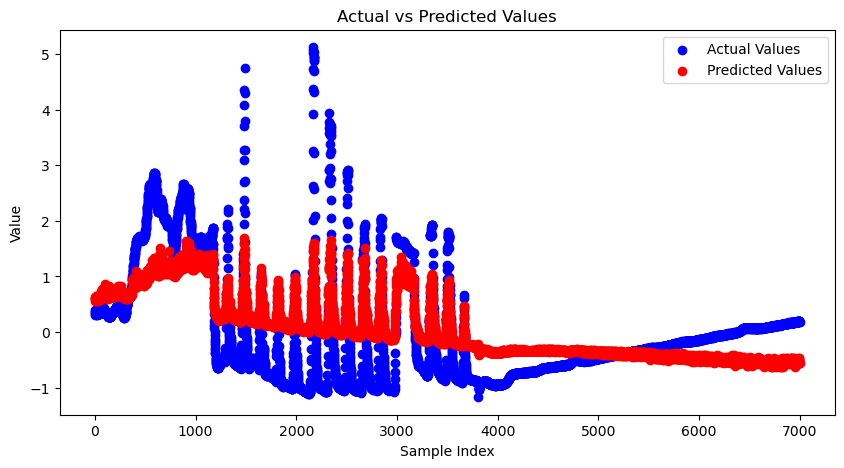

In [589]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_tensor)), y_test_tensor, color='blue', label='Actual Values')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [591]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 6),  # Input layer with 10 hidden units
            nn.ReLU(),
            nn.Linear(6, 3),  # Hidden layer with 16 hidden units
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, input_dim)

         # nn.Sigmoi# Output layer with same dimension as input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [593]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [595]:
model = Autoencoder(input_dim=15)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [597]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5307
Epoch [20/100], Loss: 0.2472
Epoch [30/100], Loss: 0.2235
Epoch [40/100], Loss: 0.1752
Epoch [50/100], Loss: 1.0562
Epoch [60/100], Loss: 1.1174
Epoch [70/100], Loss: 0.1017
Epoch [80/100], Loss: 0.0977
Epoch [90/100], Loss: 0.1333
Epoch [100/100], Loss: 1.0767


In [599]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_train_tensor)
    reconstruction_error = torch.mean((X_train_tensor - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

366


In [601]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

4.230476140975952

In [603]:
anomalies = reconstruction_error > threshold

In [605]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 6


In [607]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))
reconstruction_error

7000


array([1.2142208 , 1.2196614 , 1.212211  , ..., 0.7665109 , 0.76257986,
       0.65683204], dtype=float32)

In [609]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

1.29605233669281

In [611]:
anomalies = reconstruction_error > threshold
print(len(anomalies))

7000


In [613]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 215
